# experiments on creating a custom po2 layer

In [75]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 256
x_test = x_test.astype("float32") / 256

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.11147800087928772
Test accuracy: 0.9746000170707703


In [63]:
'''

PO2 class definition

'''


import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


class PO2Dense(keras.layers.Dense):
    def __init__(self, units, num_bits):
        super(PO2Dense, self).__init__(units=units)
    
        # tratar como se fosse numero inteiro ainda (salvando os 4 bits)
        self.max_exp = (2**(num_bits-1)-1)
        self.min_exp = - self.max_exp
    
    
    def quantize_weights(self, kernel):
        eps = keras.backend.epsilon()
        
        # quantizing the kernel
        qkernel = tf.abs(kernel)
        qkernel = tf.math.log(qkernel +  eps) / tf.math.log(2.0)
        qkernel = tf.abs(qkernel)
        qkernel = tf.round(qkernel) 
        qkernel = tf.clip_by_value(qkernel, 0, self.max_exp)
        qkernel = tf.sign(kernel) * tf.pow(2.0, -qkernel)
        qkernel = kernel + tf.stop_gradient(-kernel + qkernel)
        
        return qkernel
    
    def call(self, inputs):
        qkernel = self.quantize_weights(self.kernel)
        qbias = self.quantize_weights(self.bias)
        x = tf.tensordot(inputs, qkernel, axes=1)
        x = tf.add(qbias, x)
        return x

po2_layer = PO2Dense(1, 4)(np.ones((1, 5)))

In [64]:
x = x_in = keras.Input(input_shape)
x = keras.layers.Flatten()(x)
x = keras.layers.ReLU()(x)
x = PO2Dense(256, 4)(x)
x = keras.layers.ReLU()(x)
x = PO2Dense(256, 4)(x)
x = keras.layers.ReLU()(x)
x = PO2Dense(10, 4)(x)
x = keras.layers.Softmax()(x)
model = keras.models.Model(inputs=x_in, outputs=[x])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_14 (Flatten)        (None, 784)               0         
                                                                 
 re_lu_32 (ReLU)             (None, 784)               0         
                                                                 
 po2_dense_46 (PO2Dense)     (None, 256)               200960    
                                                                 
 re_lu_33 (ReLU)             (None, 256)               0         
                                                                 
 po2_dense_47 (PO2Dense)     (None, 256)               65792     
                                                                 
 re_lu_34 (ReLU)             (None, 256)               0   

In [65]:
batch_size = 128
epochs = 15
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 4s 8ms/step - loss: 0.2802 - accuracy: 0.9191 - val_loss: 0.1083 - val_accuracy: 0.9692
Epoch 2/15
422/422 [==============================] - 3s 7ms/step - loss: 0.1085 - accuracy: 0.9670 - val_loss: 0.1018 - val_accuracy: 0.9702
Epoch 3/15
422/422 [==============================] - 3s 7ms/step - loss: 0.0717 - accuracy: 0.9777 - val_loss: 0.0801 - val_accuracy: 0.9742
Epoch 4/15
422/422 [==============================] - 3s 8ms/step - loss: 0.0517 - accuracy: 0.9837 - val_loss: 0.0794 - val_accuracy: 0.9758
Epoch 5/15
422/422 [==============================] - 3s 8ms/step - loss: 0.0407 - accuracy: 0.9874 - val_loss: 0.0694 - val_accuracy: 0.9798
Epoch 6/15
422/422 [==============================] - 3s 7ms/step - loss: 0.0302 - accuracy: 0.9901 - val_loss: 0.0813 - val_accuracy: 0.9772
Epoch 7/15
422/422 [==============================] - 3s 7ms/step - loss: 0.0253 - accuracy: 0.9917 - val_loss: 0.0738 - val_accuracy: 0.9825
Epoch 

input_16
flatten_14
re_lu_32
po2_dense_46


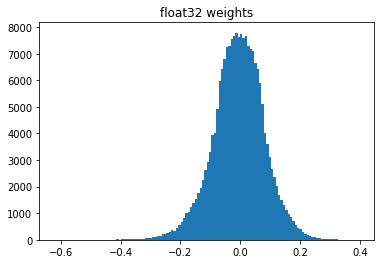

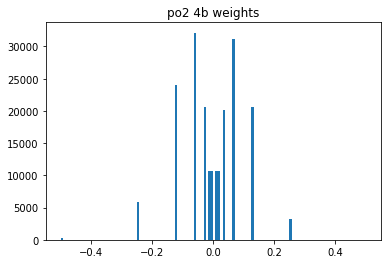

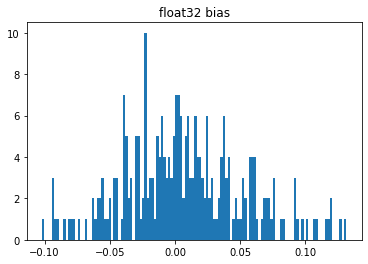

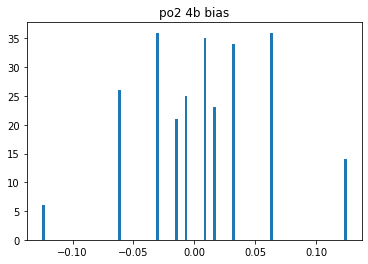

re_lu_33
po2_dense_47


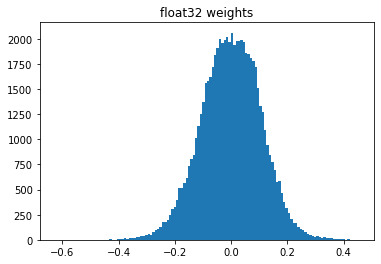

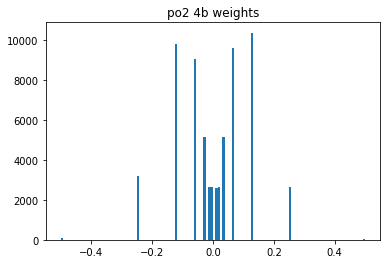

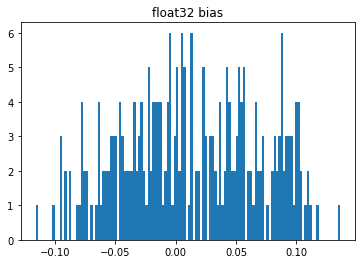

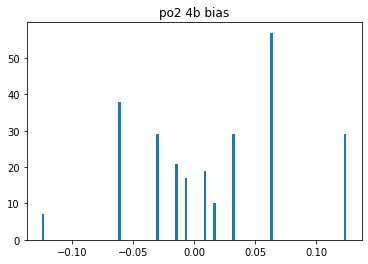

re_lu_34
po2_dense_48


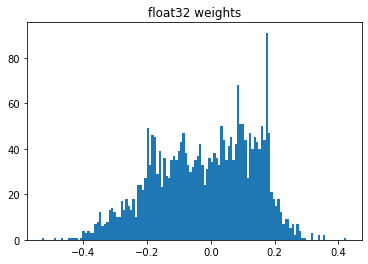

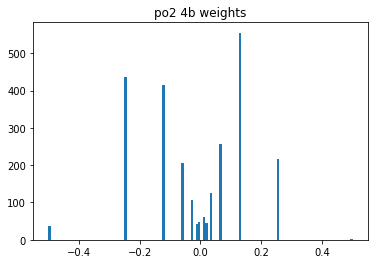

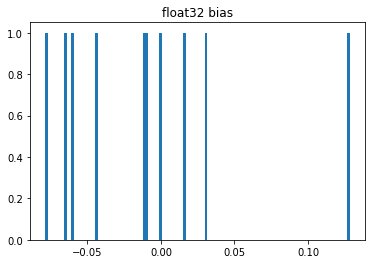

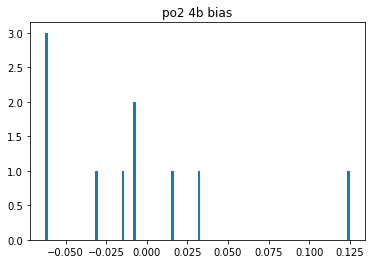

softmax_8


In [83]:
for l in model.layers:
    print(l.name)
    if not isinstance(l, PO2Dense):
        continue
    
    
    w = l.get_weights()[0]
    qw = l.quantize_weights(l.get_weights()[0])
    
    b = (l.get_weights()[1])
    qb = l.quantize_weights(l.get_weights()[1])
    
    
    plt.hist(np.ravel(w), 128)
    plt.title("float32 weights")
    plt.show()
    
    plt.hist(np.ravel(qw), 128) 
    plt.title("po2 4b weights")
    plt.show()
    
    plt.hist(np.ravel(b), 128) 
    plt.title("float32 bias")
    plt.show()
    
    plt.hist(np.ravel(qb), 128) 
    plt.title("po2 4b bias")
    plt.show()
    
    